In [14]:
import pandas as pd # dataframe manipulation
import numpy as np

# sklearn 
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from sklearn.decomposition import PCA

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

In [15]:
data = pd.read_csv('bike_buyers_clean.csv')
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes


In [16]:
# Columns lists
categorical_cols = ['Marital Status', 'Gender', 'Occupation', 'Home Owner', 'Region', 'Purchased Bike']
ordinal_cols = ['Education', 'Commute Distance']
numerical_cols = ['Income', 'Children', 'Cars', 'Age']

# Create a transformer for each data type
# Transfomer for categorical data based on OHC
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
])

# Encoding of ordinal data
ordinal_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[['Partial High School', 'High School', 'Partial College', 'Bachelors', 'Graduate Degree'], 
                                           ['0-1 Miles', '1-2 Miles', '2-5 Miles', '5-10 Miles', '10+ Miles']])) 
])

# Powertransformer normalises data with the assumtption that data is normaly distributed
numerical_transformer = Pipeline(steps=[
    ("transformer", PowerTransformer())
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

# Full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


pipeline.fit(data)
transformed_data = pipeline.transform(data)

/Users/alexander/Desktop/projects/data_analytics/.data_analytics/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [39]:
# create a df from transformed data to have a better understanding of data
transformed_df = pd.DataFrame(transformed_data, columns = pipeline.fit(data).get_feature_names_out().tolist())
transformed_df

/Users/alexander/Desktop/projects/data_analytics/.data_analytics/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,cat__Marital Status_Single,cat__Gender_Male,cat__Occupation_Management,cat__Occupation_Manual,cat__Occupation_Professional,cat__Occupation_Skilled Manual,cat__Home Owner_Yes,cat__Region_North America,cat__Region_Pacific,cat__Purchased Bike_Yes,ord__Education,ord__Commute Distance,num__Income,num__Children,num__Cars,num__Age
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,-0.394012,-0.390951,-1.441223,-0.067828
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,-0.799762,0.771203,-0.277524,0.024350
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.831899,1.567855,0.581853,1.321997
3,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,3.0,0.564771,-1.340990,-0.277524,-0.162293
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,-0.799762,-1.340990,-1.441223,-0.673208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.275895,0.260296,0.581853,0.913176
996,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,2.0,0.564771,1.197992,-1.441223,-0.784107
997,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,3.0,0.0,0.275895,0.260296,-1.441223,-0.460588
998,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.316118,0.771203,1.288811,-0.460588


In [18]:
# Outliers
detector = ECOD()
detector.fit(transformed_df)
outliers = detector.predict(transformed_df)
transformed_df['outliers'] = outliers

In [19]:
data_no_outliers = transformed_df[transformed_df['outliers']==0].drop(["outliers"], axis = 1)
data_with_outliers = transformed_df.copy().drop(["outliers"], axis = 1)

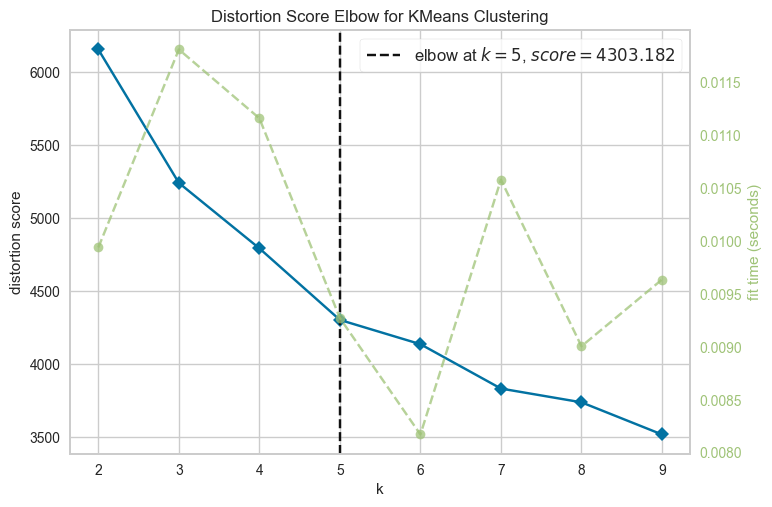

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(data_no_outliers)
visualizer.show()

In [9]:
km = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init = 10, max_iter=10000)
clusters = km.fit_predict(data_no_outliers)

In [11]:
# Measure how this clustering performed
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

print(f"Davies bouldin score: {davies_bouldin_score(data_no_outliers,clusters)}")
print(f"Silhouette Score: {silhouette_score(data_no_outliers,clusters)}")

Davies bouldin score: 1.6411690000464865
Silhouette Score: 0.18963965763040255


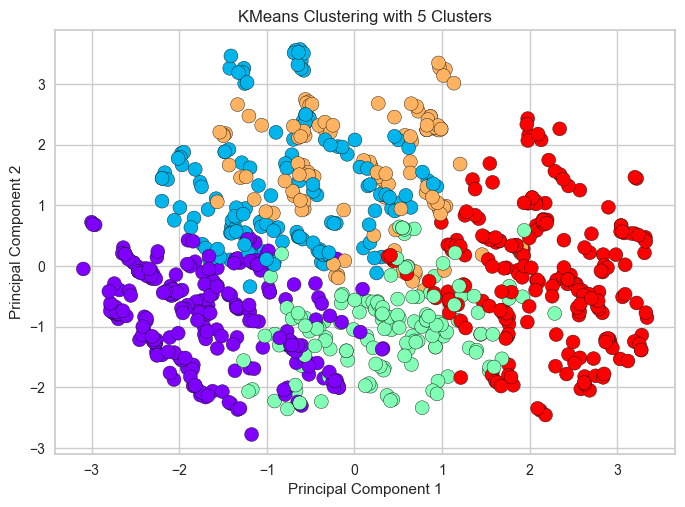

In [10]:
## PCA to reduce dimesnions and visualise clusters differentiation
import matplotlib.pyplot as plt

# Reduce data to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_no_outliers)

# Plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='rainbow', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with 5 Clusters')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


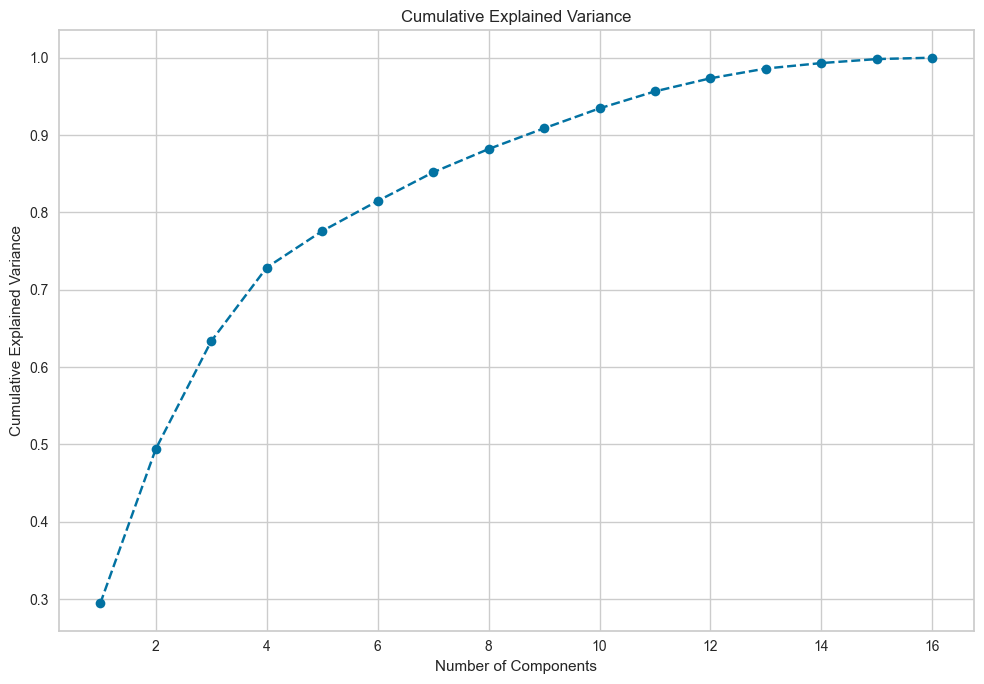

In [69]:
# Assuming your data is in a variable called `data`
pca = PCA().fit(data_no_outliers)

# Calculate cumulative sum of explained variances
cum_sum = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cum_sum) + 1), cum_sum, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Principal Component 3')

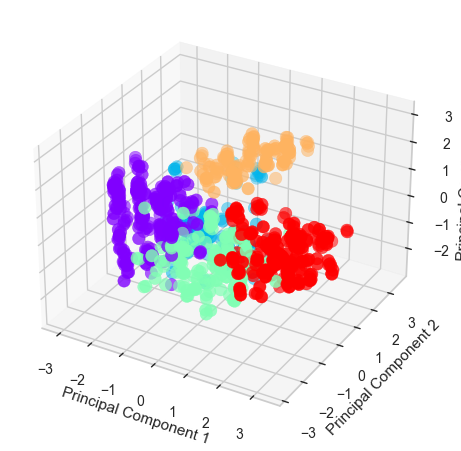

In [19]:
## PCA to reduce dimensions and visualise clusters differentiation
import matplotlib.pyplot as plt

# Reduce data to 3D
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_no_outliers)

# 3D-Plot
graph = plt.figure()
axis = graph.add_subplot(projection="3d")
xdata = data_pca[:, 0]
ydata = data_pca[:, 1]
zdata = data_pca[:, 2]
axis.scatter3D(xdata, ydata, zdata, c=clusters, cmap = "rainbow", s=80)
axis.set_xlabel("Principal Component 1")
axis.set_ylabel("Principal Component 2")
axis.set_zlabel("Principal Component 3")

In [13]:
# creating summary of a cluster
data['outliers'] = outliers
data = data[data['outliers']==0]
data['clusters'] = clusters
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike,outliers,clusters
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No,0,0
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No,0,1
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No,0,4
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes,0,3
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes,0,0


Explanation of clusters	

In [20]:
final_df = data.groupby('clusters').agg({
    'Gender':pd.Series.mode,
    'Marital Status':pd.Series.mode,
    'Income':pd.Series.mean, 
    'Children':pd.Series.median,
    'Education':pd.Series.mode,
    'Occupation':pd.Series.mode,
    'Home Owner':pd.Series.mode,
    'Cars':pd.Series.median,
    'Commute Distance':pd.Series.mode,
    'Region':pd.Series.mode,	
    'Age':pd.Series.median,	
    'Purchased Bike':pd.Series.mode
    })
final_df['Income'] = final_df['Income'].apply(lambda x: round(x, 2))
final_df['Cars'] = final_df['Cars'].astype(int)
final_df['Children'] = final_df['Children'].astype(int)
final_df

,Gender,Marital Status,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
clusters,,,,,,,,,,,,
0,Female,Married,50760.00,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,North America,38.0,Yes
1,Female,Single,25961.54,2,Partial College,Manual,Yes,1,0-1 Miles,Europe,43.5,No
2,Male,Married,83466.67,3,Bachelors,Management,Yes,2,0-1 Miles,North America,45.0,No
3,Male,Single,44538.46,0,Partial College,Skilled Manual,Yes,1,5-10 Miles,North America,30.0,No
4,Male,Married,62663.55,3,Partial College,Professional,Yes,2,5-10 Miles,North America,54.0,No


In [40]:
# Computation of mean variance
transformed_df_cluster = transformed_df
transformed_df["mean"] = transformed_df.mean(axis=1)

mean_vector = []

for x in transformed_df["mean"]:
    mean_vector.append(x)

sample_mean = transformed_df["mean"].mean()

variance_placeholder = []

for x in mean_vector:
    y = (x-sample_mean)**2
    variance_placeholder.append(y)

n_1 = len(variance_placeholder)-1

var_sum = sum(variance_placeholder)

sample_variance = var_sum/n_1
transformed_df_cluster.drop(columns=['mean'], inplace=True)

sample_variance

0.06741628853605261

In [29]:
cat_vars  = transformed_df_cluster.columns.to_list()[:10]
cat_vars

['cat__Marital Status_Single',
 'cat__Gender_Male',
 'cat__Occupation_Management',
 'cat__Occupation_Manual',
 'cat__Occupation_Professional',
 'cat__Occupation_Skilled Manual',
 'cat__Home Owner_Yes',
 'cat__Region_North America',
 'cat__Region_Pacific',
 'cat__Purchased Bike_Yes']

In [30]:
cat_vector_mean = []
for col in cat_vars:
    cat_vector_mean.append(transformed_df[f"{col}"].mean())

cat_mean = sum(cat_vector_mean)/len(cat_vector_mean)

cat_var_list = []

for x in cat_vector_mean:
    y = (x-cat_mean)**2
    cat_var_list.append(y)

cat_variance = sum(cat_var_list)/(len(cat_var_list)-1)

print(cat_variance)

0.03484210000000001


In [41]:
data_no_outliers["cluster"] = clusters

filter_0 = data_no_outliers[data_no_outliers["cluster"]==0]
filter_1 = data_no_outliers[data_no_outliers["cluster"]==1]
filter_2 = data_no_outliers[data_no_outliers["cluster"]==2]
filter_3 = data_no_outliers[data_no_outliers["cluster"]==3]
filter_4 = data_no_outliers[data_no_outliers["cluster"]==4]



mean_vector_0 = filter_0.mean(axis=1)
mean_vector_1 = filter_1.mean(axis=1)
mean_vector_2 = filter_2.mean(axis=1)
mean_vector_3 = filter_3.mean(axis=1)
mean_vector_4 = filter_4.mean(axis=1)

mean_0 = mean_vector_0.mean()
mean_1 = mean_vector_1.mean()
mean_2 = mean_vector_2.mean()
mean_3 = mean_vector_3.mean()
mean_4 = mean_vector_4.mean()


cluster_variance_list_0 = []
cluster_variance_list_1 = []
cluster_variance_list_2 = []
cluster_variance_list_3 = []
cluster_variance_list_4 = []


for x in mean_vector_0:
    y = (mean_0-x)**2
    cluster_variance_list_0.append(y)

for x in mean_vector_1:
    y = (mean_1-x)**2
    cluster_variance_list_1.append(y)

for x in mean_vector_2:
    y = (mean_2-x)**2
    cluster_variance_list_2.append(y)

for x in mean_vector_3:
    y = (mean_3-x)**2
    cluster_variance_list_3.append(y)

for x in mean_vector_4:
    y = (mean_4-x)**2
    cluster_variance_list_4.append(y)

var_0 = sum(cluster_variance_list_0)/(len(cluster_variance_list_0)-1)
var_1 = sum(cluster_variance_list_1)/(len(cluster_variance_list_1)-1)
var_2 = sum(cluster_variance_list_2)/(len(cluster_variance_list_2)-1)
var_3 = sum(cluster_variance_list_3)/(len(cluster_variance_list_3)-1)
var_4 = sum(cluster_variance_list_4)/(len(cluster_variance_list_4)-1)


within_cluster_var = (var_0 + var_1 + var_2 + var_3 + var_4)/5

print(within_cluster_var)

0.019698182959346687
